![SE03.png](Figs/SE03.png)

**Welcome to the final notebook in the series!**

So far, you have:
1. Modeled the Texas power grid in [`SE01`](SE01_Power_Network_Model.ipynb)
2. Simulated a windstorm hazard and determined the affected network assets in [`SE02`](SE02_Hazard_Scenarios.ipynb).

In this concluding notebook, we will bring everything together to perform a full resilience assessment. We will quantify the impact of the windstorm in terms of energy not supplied (ENS) and investigate how distribution network and demand-side flexibility can be used as an effective mitigation measure.

### **Learning Objectives:** 
By the end of this notebook, you will be able to:
- Simulate the operational impact of the windstorm on the power grid
- Use a fragility model to calculate the failure probability of network components exposed to the storm
- Calculate Energy Not Supplied (ENS) as a key resilience metric
- Model and incorporate the effects of distribution-side flexibility

### **List of contents**
- [Introduction to Resilience Assessment](#1.-Introduction-to-Resilience-Assessment )
- [Loading Required Libraries](#2.-Loading-Required-Libraries)
- [Loading the Models and Scenarios](#3.-Loading-the-Models-and-Scenarios)
- [The Resilience Assessment Framework](#4.-The-Resilience-Assessment-Framework)
- [Case Study: Impact of a Specific Windstorm on Network Resilience](#5.-Case-Study:-Impact-of-a-Specific-Windstorm-on-Network-Resilience)
    - [Propagation Effects within Windstorm Envelopes](#5.1-Propagation-Effects-within-Windstorm-Envelopes)
    - [Stochastic Failure Simulation Based on Fragility Curve](#5.2-Stochastic-Failure-Simulation-Based-on-Fragility-Curve)
    - [Visualize and Quantify Network Line Damage](#5.3-Visualize-and-Quantify-Network-Line-Damage)
    - [Animating propagation](#5.4-Animating-propagation)
- [Assessing Windstorm Impact on System Resilience](#6.-Assessing-Windstorm-Impact-on-System-Resilience)
    - [Adding Virtual Generators to Simulate Load Shedding](#6.1-Adding-Virtual-Generators-to-Simulate-Load-Shedding)
    - [Centralised Supply through the Transmission Network](#6.2-Centralised-Supply-through-the-Transmission-Network)
    - [Distribution Networks and Microgrid Demand-Side Flexibility](#6.3-Distribution-Networks-and-Microgrid-Demand-Side-Flexibility)
    - [Define DS flexibility parameters](#6.4-Define-DS-flexibility-parameters)
    - [Comparison: With and Without Distribution Flexibility](#6.5-Comparison:-With-and-Without-Distribution-Flexibility)
- [Tutorial Conclusion](#7.-Tutorial-Conclusion)

### 1. Introduction to Resilience Assessment 
This notebook integrates the work from the previous two parts to conduct a comprehensive resilience analysis. We will use the affected components determined in [`SE02`](SE02_Hazard_Scenarios.ipynb) to simulate the operational impact of the windstorm on the power network from [`SE01`](SE01_Power_Network_Model.ipynb)

The primary goal is to quantify the system's performance degradation, measured by the **Energy Not Supplied (ENS)**. We will then introduce **demand-side (DS) flexibility**—representing resources like battery storage or demand response—as a mitigation strategy. By comparing the system's performance with and without this flexibility, we can quantitatively assess its value in enhancing power grid resilience

### 2. Loading Required Libraries
We start by importing the necessary Python packages to facilitate the analysis and visualization

In [1]:
from QRA.engines.WindStorm import WindClass, WindConfig  # Load windstorm modelling tools
from QRA.engines.Network import NetworkConfig, NetworkClass  # Load network modelling tools
import random
import geopandas as gpd
import pandapower as pp
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import matplotlib.pyplot as plt
import pandapower.plotting as plot
import numpy as np
import pandas as pd
from IPython.display import display, HTML

### 3. Loading the Models and Scenarios
First, we load the power network model and initialize the windstorm scenarios, just as we did in the previous notebooks. We set a specific seed to ensure our analysis is based on the same repeatable storm event.

In [2]:
wcon = WindConfig()  # Assigning wind configuration to a variable
wcon.set_seed(0)  # Setting a specific seed for the random number generator
ws = WindClass(wcon)  # Passing the modelling configuration to the tool
# Load power network
nc = NetworkClass(NetworkConfig())
net = nc._get_model()

# Initialise windstorm scenarios
ws._init_ws_path0()
NumWS = ws._get_num_ws_total()
Lon, Lat, Lon_n, Lat_n = ws._init_ws_path(NumWS)

# Display scenario information
print(f"{NumWS} windstorm scenarios are generated.")
print(f"Each scenario is defined by a start point (near coast) and end point (inland),")
print("representing a plausible storm path affecting the Texas grid.")

1978 windstorm scenarios are generated.
Each scenario is defined by a start point (near coast) and end point (inland),
representing a plausible storm path affecting the Texas grid.


### 4. The Resilience Assessment Framework
To assess resilience, we need a framework that can handle the uncertainty of component failures and quantify the resulting operational impacts. Our approach combines three key elements:
1. Monte Carlo Simulation: Since a component's failure is probabilistic (not certain), we cannot analyze just one outcome. Instead, we use a **Monte Carlo simulation**. This involves running many simulations where, for each sample, we randomly determine whether a component fails based on its failure probability ($P_f$). By averaging the results over many samples, we get a robust estimate of the expected system performance.

2. DC Optimal Power Flow (DC-OPF): For each Monte Carlo sample, we have a specific set of failed components. To determine the impact of these outages, we run a **DC Optimal Power Flow (DC-OPF)**. The DC-OPF calculates how power flows through the remaining network and, crucially, identifies how much load cannot be supplied due to the outages.

3. Energy Not Supplied (ENS) 
The primary metric we use to quantify resilience is **Energy Not Supplied (ENS)**. It represents the total amount of energy (in MWh) that could not be delivered to customers during the storm event. A lower ENS indicates a more resilient system. We calculate the ENS for each hour of the storm and sum it up to get the total impact.


### 5. Case Study: Impact of a Specific Windstorm on Network Resilience
While many windstorm scenarios can be simulated to capture the full spectrum of potential threats to the power grid, it is often useful to examine a representative event in detail. In this section, one windstorm scenario is selected to illustrate:
- Its path and characteristics (e.g., speed, duration, trajectory),
- The resulting exposure of power system assets,
- Its potential impact on operational performance and resilience.

🌪️ Windstorm 686: 32h | Speed: 53.7-17.0 m/s | Start: (-95.64,28.47) → End: (-105.61,33.79)


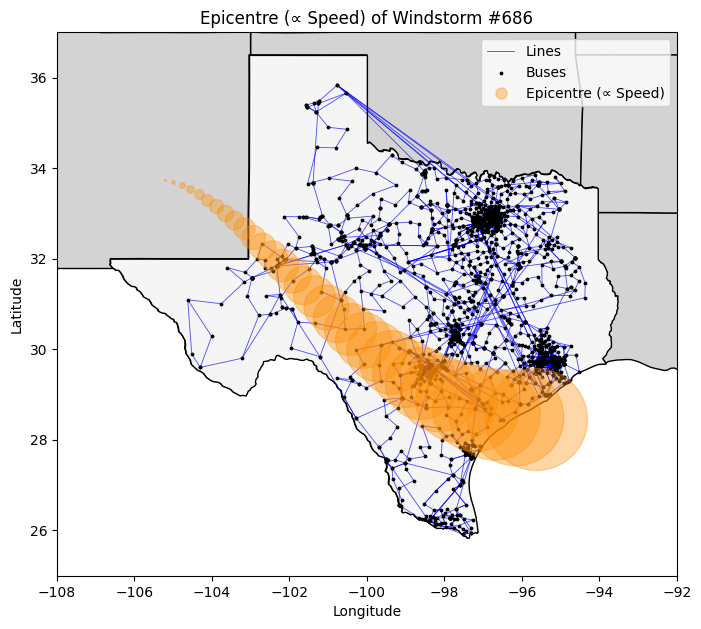

In [3]:
# --- Select a reproducible windstorm scenario ---
random.seed(242)
idx = random.choice(range(NumWS))
Num_hrs = ws._get_lng_ws()[idx]
lim_v_ws = ws._get_lim_v_ws()
vmin, vmax = lim_v_ws[0][idx], lim_v_ws[1][idx]
start, end = (Lon[idx], Lat[idx]), (Lon_n[idx], Lat_n[idx])

# --- Get hourly path and wind speeds ---
path_ws = ws._crt_ws_path(*start, *end, vmin, Num_hrs)
print(f"🌪️ Windstorm {idx}: {Num_hrs}h | Speed: {vmin:.1f}-{vmax:.1f} m/s | Start: ({path_ws[0][0]:.2f},{path_ws[0][1]:.2f}) → End: ({path_ws[-1][0]:.2f},{path_ws[-1][1]:.2f})")
v_ws = np.array(ws._crt_ws_v([vmin, vmax], Num_hrs))
v_ws_scaled = 2 * (v_ws - v_ws.min() + 1e-3)

# --- Plot map, grid, and epicentres ---
fig, ax = plt.subplots(figsize=(8, 8))
ws.plot_base(ax, net)
for x, y, s in zip(*zip(*path_ws), v_ws_scaled):
    ax.plot(x, y, 'o', markersize=s, color='darkorange', alpha=0.35, zorder=4)

ax.set(title=f"Epicentre (∝ Speed) of Windstorm #{idx}", xlim=(-108, -92), ylim=(25, 37), xlabel="Longitude", ylabel="Latitude")
ax.plot([], [], 'o', color='darkorange', markersize=8, alpha=0.35, label='Epicentre (∝ Speed)')
ax.legend()
plt.show()

#### 5.1 Propagation Effects within Windstorm Envelopes
Building on the previous analysis of windstorm trajectories and epicentres, this section examines how the moving storm envelope interacts with the power network. The goal is to visualise the geographical spread of storm impact as it moves hour by hour, and to clearly illustrate which network assets are exposed at each stage.

Two types of spatial envelopes are used to represent the affected area:
- **Rectangular envelopes**: connecting consecutive epicentres, outlining the region swept by the storm during each hourly interval.
- **Circular envelopes**: centred at each hourly epicentre, with a fixed radius (e.g., 20 km), representing the area directly exposed to damaging wind speeds.

The workflow for this analysis is as follows:
- Detect network assets inside the storm envelopes at each time step, identifying lines and substations potentially at risk.
- Display the propagation envelopes and highlight affected assets on the network map.
- Calculate failure probabilities for exposed components, based on appropriate fragility models.
- Animate the storm’s progression, showing the dynamic exposure and risk over time.

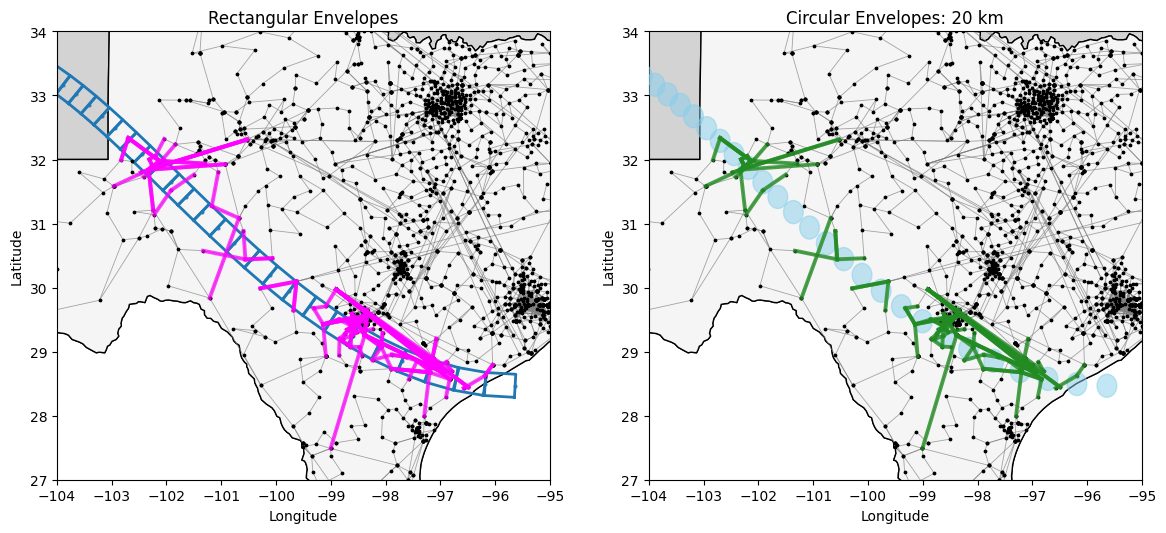

In [4]:
# --- PARAMETERS ---
radius_km = 20  # Envelope radius (km)
gis_line_bgn, gis_line_end = nc._get_line_coords()
num_lines, num_bus, num_gen = len(net.line), len(net.bus), len(net.sgen)
envelopes_rect, envelopes_circ, affected_lines_rect, affected_lines_circ = [None] * Num_hrs, [None] * Num_hrs, [None] * Num_hrs, [None] * Num_hrs

# --- Identify affected lines (rectangles and circles) ---
for i in range(Num_hrs):
    centre = path_ws[i]
    envelopes_circ[i] = centre
    affected_lines_circ[i] = np.where(ws._compare_circle(centre, radius_km, gis_line_bgn, gis_line_end, num_lines))[0]
    if i < Num_hrs - 1:
        rect = ws._crt_envelope(path_ws[i], path_ws[i+1], radius_km)
        envelopes_rect[i] = rect
        affected_lines_rect[i] = np.where(ws._compare_envelope(rect, gis_line_bgn, gis_line_end, num_lines))[0]

# Plot rectangles and affected lines
fig, (ax_rect, ax_circ) = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)
ws.plot_base(ax_rect, net,line_color='tab:gray')
ws.plot_base(ax_circ, net,line_color='tab:gray')

evlp_seq = [0, 2, 3, 1, 0]
ax_rect.set_title("Rectangular Envelopes")
for i, evlp in enumerate(envelopes_rect[:-1]):
    if evlp is not None:
        evlp = np.array(evlp)
        ax_rect.plot(evlp[evlp_seq, 0], evlp[evlp_seq, 1], '-', color='tab:blue', lw=2, label='Rectangle' if i == 0 else "")
        ax_rect.plot(path_ws[i][0], path_ws[i][1], 'o', color='tab:blue', ms=2, alpha=0.8)
    for idx in affected_lines_rect[i]:
        ax_rect.plot([gis_line_bgn[idx][0], gis_line_end[idx][0]], [gis_line_bgn[idx][1], gis_line_end[idx][1]], color='magenta', lw=2.8, alpha=0.75, zorder=5)

# Plot circles and affected lines
ax_circ.set_title(f"Circular Envelopes: {radius_km} km")
for i, centre in enumerate(envelopes_circ):
    ax_circ.add_patch(plt.Circle(centre, radius_km / 111, color='skyblue', alpha=0.5, zorder=4, label="Circle" if i == 0 else ""))
    for idx in affected_lines_circ[i]:
        ax_circ.plot([gis_line_bgn[idx][0], gis_line_end[idx][0]], [gis_line_bgn[idx][1], gis_line_end[idx][1]], color='forestgreen', lw=2.8, alpha=0.8, zorder=5)

# Axis and display
for ax in (ax_rect, ax_circ):
    ax.set(xlim=(-104, -95), ylim=(27, 34), xlabel="Longitude", ylabel="Latitude")
ax_circ.yaxis.set_tick_params(labelleft=True)
plt.show()

#### 5.2 Stochastic Failure Simulation Based on Fragility Curve
While the previous section highlighted which transmission lines are exposed within the moving storm envelope at each hour, not every exposed line will necessarily fail. Instead, each line’s likelihood of failure is governed by a fragility curve, which links wind speed to failure probability. This step introduces stochasticity: for each hour, lines identified as affected are assessed individually, and their failure is sampled according to the probability determined by the local wind speed.

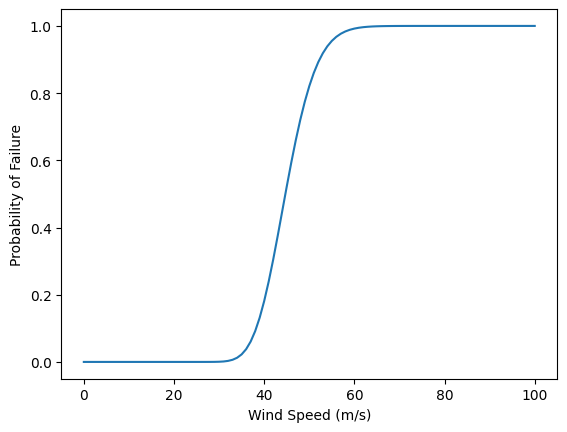

In [5]:
wind_speed = np.arange(0, 101, 1)
PoF = [ws._fragility_curve(i) for i in wind_speed]
plt.plot(wind_speed, PoF)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability of Failure')
plt.show()

#### 5.3 Visualize and Quantify Network Line Damage
The affected and failed lines are plotted on a map of the network, providing an immediate visual overview of the geographical extent and severity of damage caused by the windstorm. This spatial illustration enables quick assessment of which areas are most impacted. In addition, the progression of network failures is quantified by plotting the number of failed lines over time.

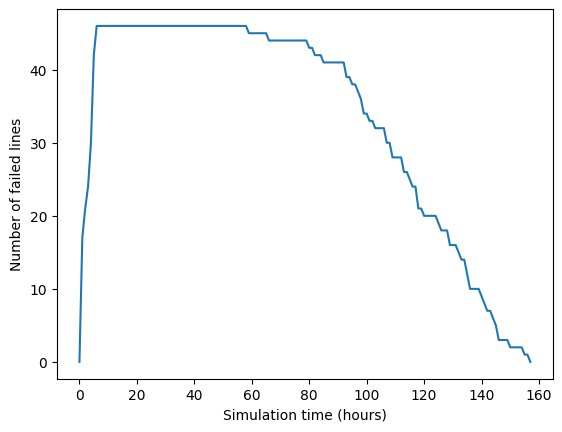

In [18]:
# --- Setup ---
is_failed_ohl = np.zeros(num_lines, dtype=int) 
failed_total = [[] for _ in range(Num_hrs)]    
affected_idx = [set() for _ in range(Num_hrs)]  
bgn_off_hr_ohl = np.zeros(num_lines)
end_rec_hr_ohl = np.zeros(num_lines) 
idx_ohl = net.line.index
lim_ttr = ws._get_lim_ttr() 

# --- Windstorm simulation loop ---
for i_hr in range(Num_hrs):
    p_fail = ws._fragility_curve(v_ws[i_hr])
    affected_rect = affected_lines_rect[i_hr] if affected_lines_rect[i_hr] is not None else []
    affected_circ = affected_lines_circ[i_hr] if affected_lines_circ[i_hr] is not None else []
    affected_idx[i_hr] = set(affected_rect) | set(affected_circ)

    for idx in affected_idx[i_hr]:
        if not is_failed_ohl[idx]:
            if np.random.rand() < p_fail:
                is_failed_ohl[idx] = 1  # Mark line as failed
                bgn_off_hr_ohl[idx] = i_hr - 1
                rnd_hr = (np.random.randn() + 3.5) * lim_ttr[0]  # Generate a random factor; the 3.5 multiplier could be refined
                ttr_ohl = round(min(max(lim_ttr[0], rnd_hr), lim_ttr[1])) 
                end_rec_hr_ohl[idx] = Num_hrs + ttr_ohl - 1
    # Save indices of lines failed up to this hour
    failed_total[i_hr] = [idx for idx, failed in enumerate(is_failed_ohl) if failed]
    
num_hrs_yr = ws._get_num_hrs_yr() # Get total hours in a year for the simulation
line_status = [[True for _ in range(num_hrs_yr)] for _ in range(num_lines)] # Initialise line status (True = operational)
ens_bus = np.zeros((num_bus, num_hrs_yr)) # Initialise energy not served for each bus

# Update line status based on failures detected in the simulation
if any(value is not None for value in failed_total):
    idx_off_ohl = np.where(bgn_off_hr_ohl > 0)[0] # Indexes of lines with downtime
    for i_off_ohl in idx_off_ohl:
        # Set the line status to False (failed) for the duration of the outage
        start_idx = int(bgn_off_hr_ohl[i_off_ohl])
        end_idx = int(end_rec_hr_ohl[i_off_ohl])  
        idx_ohl_i_off_ohl = int(idx_ohl[i_off_ohl])
        line_status[idx_ohl_i_off_ohl][start_idx:end_idx] = [False] * (end_idx - start_idx)
    
    line_status_array = np.array(line_status) # Convert line status to an array for analysis
    failed_lines_per_hour = []  # List of sets, one for each hour

    for i_hr in range(num_hrs_yr):
        failed_now = set(np.where(line_status_array[:, i_hr] == False)[0])# Get indices of failed lines for this hour
        failed_lines_per_hour.append(failed_now)

    # Calculate and plot the number of failed lines over time
    start = int(min(bgn_off_hr_ohl[bgn_off_hr_ohl > 0]))
    end = int(max(end_rec_hr_ohl))
    sums = [np.sum(line_status_array[:, hour] == False) for hour in range(start - 1, end + 1)]
    plt.plot(list(range(start - 1, end + 1)), sums)
    plt.xlabel("Simulation time (hours)")
    plt.ylabel("Number of failed lines")
    plt.show()

#### 5.4 Animating propagation
This animation is designed to dynamically show the path of the storm through the network, highlighting the gradual impact on network assets over time. In this animation, affected lines (those within the windstorm's path but not necessarily failed) are highlighted in orange for the current hour, greying them out afterwards to indicate past impact without failure. The failed lines are marked in red, in sync with the windstorm's path. 

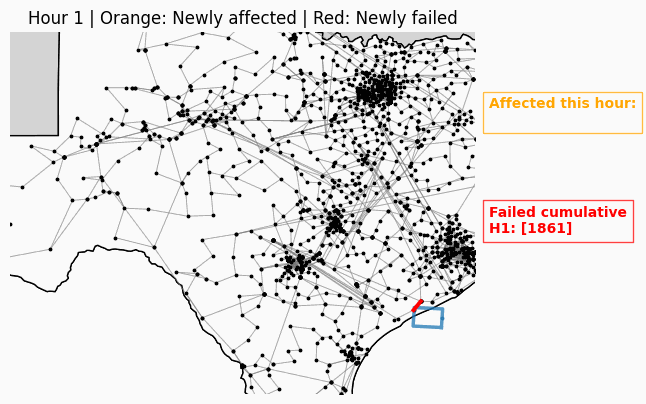

In [19]:
ws.ws_animation(net, envelopes_rect, affected_idx, failed_total, 22, path_ws,fps = 1)

### 6. Assessing Windstorm Impact on System Resilience
The resilience of a power system during a windstorm is commonly assessed by calculating the amount of unserved energy — Energy Not Supplied (ENS) to customers due to power interruptions caused by extreme weather.

This section introduces the use of virtual (dummy) generators to simulate demand disconnection. The method allows for the calculation of demand not met (load shedding) and investigates how demand-side flexibility affects resilience.

#### 6.1 Adding Virtual Generators to Simulate Load Shedding
To measure resilience, a virtual generator is added to each load bus. Each is sized to match local demand but set at a very high cost, ensuring these units only operate when the actual generation cannot meet demand.

All generators are configured as dispatchable (controllable within their allowed range), while all loads are set as non-controllable.

In [20]:
nc = NetworkClass(NetworkConfig())
net = nc._get_model()

# Set all generators as controllable
net.sgen.loc[:, 'controllable'] = True
net.gen.loc[:, 'controllable'] = True

# Set all loads as non-controllable
net.load.loc[:, 'controllable'] = False

# Add virtual generators to all load buses for load shedding simulation
net_VG = nc._add_virtual_gen(net)


OPF calculation complete. Converged: True
✅ DC OPF converged successfully with virtual generators.


#### 6.2 Centralised Supply through the Transmission Network
- All demand is supplied passively by the transmission network. 
- Local generation cannot be directly used to support demand, and there is no ability to share resources between areas. 
- If the network separates due to a windstorm or other disturbance, each islanded section relies solely on its available transmission-connected generation. 

![TraditionalPowerGrid.png](Figs/TraditionalPowerGrid.png)

#### 6.3 Distribution Networks and Microgrid Demand-Side Flexibility
When faults or extreme events cause parts of the transmission or distribution network to become isolated, flexibility at the distribution level becomes essential. Distribution networks can use local resources — such as microgrids or distributed generators — to maintain supply to local demand, even if cut off from the main grid.

**(a) Transmission Network Resilience Enhancement:**
When faults occur on the transmission network and isolate certain areas, microgrids connected to the downstream distribution network (microgrids 1 & 2) can supply power locally, helping to maintain supply despite the disruption.

**(b) Distribution Network Resilience Enhancement:**
If the distribution network itself becomes isolated, microgrids within the distribution system (microgrids 1 & 2) can act as local sources to keep the power on for connected demand.

**(c) Individual Microgrid Resilience Enhancement:**
Should a microgrid (microgrid 2) become isolated due to a failure in the distribution network, it can operate independently (islanded mode), using its local generation to cover critical loads.

**(d) Multi-Microgrid Resilience Enhancement:**
If multiple microgrids (microgrids 1 & 2) are isolated but remain interconnected, they can coordinate and share resources, working together to meet essential local demand and further enhance resilience.

![MG.png](Figs/MG.png)

#### 6.4 Define DS flexibility parameters
The integration of distributed generation (DG) into the power system allows the investigation of two critical scenarios:

**Scenario 1: Local Supply from Distributed Generation**

A certain share of demand is supplied directly by distributed generators, reducing the burden on the transmission network. In this case, DGs are strategically connected to all load buses, represented by the `flex_profile` in the code below.

**Scenario 2: Prioritisation of Essential Demand**

Energy consumption is divided into essential and non-essential demand, reflecting the importance of different services. The `essential_demand_profile` in the code tracks the proportion of essential demand across all locations over time. 

In [21]:
DG_ratio = 0.5 # assume that DG are randomly connected to 50% of all load buses
flex_profile = nc._get_flex_hrly(DG_ratio)
essential_demand_profile = nc._get_essential_demand_hrly()

#### 6.5 Comparison: With and Without Distribution Flexibility
This section compares how distributed generation flexibility affects system resilience. The analysis focuses on the difference in unserved energy (ENS) between scenarios with and without distributed flexibility.

When a windstorm splits the network into separate islands, independent Optimal Power Flow (OPF) calculations are carried out for each island. This process quantifies the amount of load shedding required—measured by the output from virtual generators—to balance supply and demand

In [22]:
num_line, num_bus, num_gen = len(net.line), len(net.bus), len(net.sgen)
hours = np.arange(start - 1, end)
ens_no_flex = np.zeros_like(hours, dtype=float)
ens_flex = np.zeros_like(hours, dtype=float)
last_fail, last_ens, last_fail_f, last_ens_f = None, 0, None, 0

for t, hr in enumerate(hours):
    fail = tuple(sorted(failed_lines_per_hour[hr]))
    base = net_VG.deepcopy()
    base.line.loc[list(fail), 'in_service'] = False

    # No flexibility
    if fail == last_fail and t > 0:
        ens_no_flex[t] = last_ens
    else:
        net1 = base.deepcopy()
        try:
            res = net1 if len(nc._find_islands(net1)) == 1 else nc._MPC_by_Parts(net1)
            ens_no_flex[t] = last_ens = res.res_sgen.iloc[num_gen:]['p_mw'].sum()
        except: ens_no_flex[t] = last_ens = 0
        last_fail = fail

    # With flexibility
    if fail == last_fail_f and t > 0:
        ens_flex[t] = last_ens_f
    else:
        net2 = base.deepcopy()
        net2.load['p_mw'] = flex_profile[:, hr]
        try:
            resf = net2 if len(nc._find_islands(net2)) == 1 else nc._MPC_by_Parts(net2)
            ens_flex[t] = last_ens_f = resf.res_sgen.iloc[num_gen:]['p_mw'].sum()
        except: ens_flex[t] = last_ens_f = 0
        last_fail_f = fail


NOTE: Losses ONLY confine to non-essential demand

Energy not supplied (without DS flexibility): 19905.7029 MWh
Energy not supplied (with DS flexibility): 17029.3216 MWh


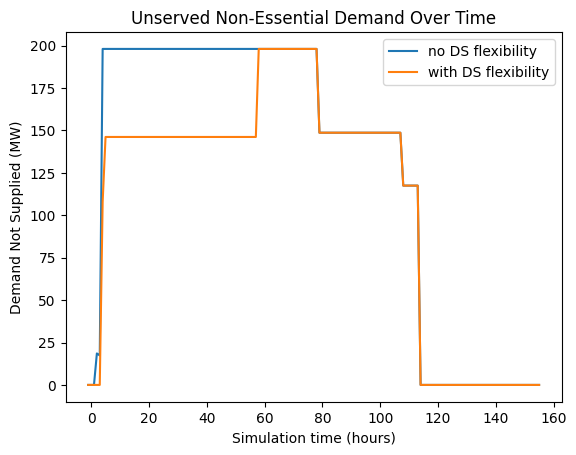

In [23]:
print("\nNOTE: Losses ONLY confine to non-essential demand\n")
print(f'Energy not supplied (without DS flexibility): {np.sum(ens_no_flex):.4f} MWh')
print(f'Energy not supplied (with DS flexibility): {np.sum(ens_flex):.4f} MWh')

plt.plot(hours - 1, ens_no_flex, label='no DS flexibility')
plt.plot(hours - 1, ens_flex, label='with DS flexibility')
plt.legend()
plt.xlabel("Simulation time (hours)")
plt.ylabel("Demand Not Supplied (MW)")
plt.title("Unserved Non-Essential Demand Over Time")
plt.show()

### 7. Tutorial Conclusion 
**Congratulations on completing the tutorial series!**
You have successfully walked through a complete workflow for power system resilience assessment:
- You started by **modeling a complex system**—the 2000-bus Texas grid.
- You then **introduced a realistic threat** by simulating a windstorm and calculating its impact on network components.
- Finally, you **quantified the system's resilience** by analyzing the energy not supplied and demonstrated how advanced resources, like distribution-side flexibility, can significantly improve performance during extreme events

This methodology provides a powerful framework for understanding and enhancing the resilience of modern energy systems against a variety of hazards.